Requires **HyperSpy 1.6.4 or above**

This tutorial introduces to the processing of large dataset - which can not fit into memory - using HyperSpy. It introduce the concept of out-of-core computation algorithms (also refer as lazy processing) and the main difference between lazy and non-lazy processing as well as technicallities you need to be aware of to optimise performance.
The corresponding section of the HyperSpy documentation is [the big data section](https://hyperspy.readthedocs.io/en/stable/user_guide/big_data.html#limitations).

### Credits and changes

* 29/07/2021 Eric Prestat. Update for the M&M Sunday short course.
* 29/07/2019 Eric Prestat. Add more details and introduction for the M&M Sunday short course.
* 15/03/2019 Francisco de la Peña. Create tutorial for the HyperSpy workshop at ePSIC.

## Table of contents
1. [Introduction to lazy processing](#1.-Introduction-to-lazy-processing)
2. [Loading data lazily](#2.-Loading-data-lazily)
3. [Plotting lazily](#3.-Plotting-lazily)
4. [EDS mapping](#4.-EDS-mapping)
5. [Rebinning](#5.-Rebinning)
6. [ROI in navigation dimension](#6.-ROI-in-navigation-dimension)
7. [Summary](#7.-Summary)

## 1. Introduction to lazy processing

Lazy processing refers to the use of [out-of-core computation algorithms](https://en.wikipedia.org/wiki/External_memory_algorithm) to process very large data, which are usually too large to fit into the computer's memory at one time. The main idea is to chunk the data in pieces, small enough, that can be processed in memory as illustrated by the following diagram:

<img src="lazy/out-of-core_diagram.svg" width="500">

HyperSpy internally uses the [dask library](https://docs.dask.org/en/latest/index.html), which implements the numpy interface to larger-than-memory or distributed environments. The typically workflow for processing data lazily is available on a disk:
 1. "load" data from disk with a defined chunking
 2. schedule operations
 3. do the computation

**Steps 1 and 2 are very fast**, because nothing is actually done, other than initialising and scheduling the tasks to be peformed.
**Step 3 is slow**, because all the computation is performed at this stage. Most of the time, this is signficantly slower than in memory processing, because the chunks of data needs to be read and written from/to disk when on request of the scheduler.

The following diagram shows a task graph, where square and rounds represent arrays and functions, respectively. This graph is an example of how dask is going process the data from the large data set on the harddrive (HDD) into chunks and do computation on these.

This example below a simple example shows of how to perform out-of-core computation using dask, here the calculation of the sum of an array:

In [1]:
import dask.array as da
# Create a 15x15 array filled with ones and chunks size to 5x5
x = da.ones((15, 15), chunks=(5, 5))

# Take the sum()
y = x.sum()

# do the computation
y.compute()

225.0

The corresponding tasks can be representated by the following graph (square are array):
 - square are arrays, which can fit into memory
 - circle are operations
 
<img src="lazy/sum.svg" width="500">

Read [the graph](https://docs.dask.org/en/latest/graphs.html) section of the dask documenation for more explanation. The taks graph can be visualised using the [visualise](https://docs.dask.org/en/latest/graphviz.html) method.

For a short ontroductory presentation on dask and its principle see http://matthewrocklin.com/slides/plotcon-2016.html. The following animation - taken from the previously mentioned presentation - illustrates the execution of the scheduled computation of many tasks:

![Dask's directed acyclic diagram (DAG)](lazy/grid_search_schedule.gif)

The implementation of out-of-core computation in HyperSpy aims to make processing very large data (not fitting into memory) as seamlessly as possible and similar to in-memory data. This tutorial covers the main difference between lazy and non-lazy processing as well as technicallities you need to be aware of to optimise performance.

## 2. Loading data lazily

As usual, we start by setting up the matplotlib backend and importing hyperspy

In [2]:
%matplotlib notebook
import hyperspy.api as hs

Let's start by setting the ``logging level`` to "INFO" using the preferences GUI as below. Once done, click ``Save`` and restart the kernel.

In [3]:
# Open the preferences GUI and set the logging level to INFO
hs.preferences.gui()

For this tutorial we are going to start by loading a large spectrum image lazily  that won't fit in the RAM of a standard laptop computer in 2018, so notice the ``lazy`` keyword and don't forget to set it to ``True``.

In [4]:
# Open lazily the file "synthetic_dataset.hspy" in the subfolder "lazy":
s = hs.load("synthetic_dataset.hspy", lazy=True)

INFO:hyperspy.io_plugins.bruker:The fast cython based bcf unpacking library were found


Let's check what sort of object we have stored in the ``s`` variable

In [5]:
s

<LazyEDSTEMSpectrum, title: , dimensions: (512, 512|992)>

This is a spectrum image with *4096* spectral channels and *512x512* image dimensions. Its size in GB:

In [6]:
# Use the "nbytes" attribute of the dask array to calculate the size on disk
s.data.nbytes / 1e9

2.080374784

In [7]:
s.data

dask.array<array, shape=(512, 512, 992), dtype=float64, chunksize=(64, 512, 248), chunktype=numpy.ndarray>

That's about *2 GB* of data. However, loading it took no time. That's because HyperSpy didn't load the data yet. It'll do it on demand.

## 3. Plotting lazily 

Let's plot the spectrum image. Usually we would call simply:

```python
s.plot()
```

And a navigator would appear. The navigator is the sum over the signal dimension and in case of large data, computing the navigator can be too long, because it means that we will need to go through the whole dataset.

For a "lazy" signal, the navigator is computed slightly differently: the navigator is computed using a single chunk in the signal dimension. If the chunking is appropriate, it can be fast.

<IPython.core.display.Javascript object>


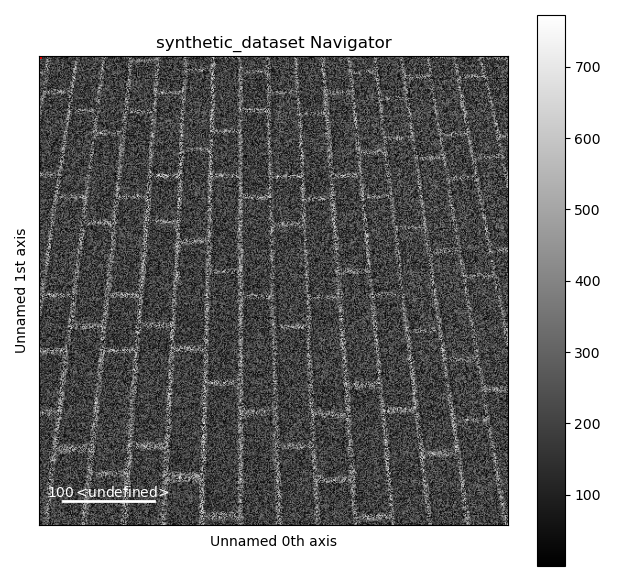

<IPython.core.display.Javascript object>


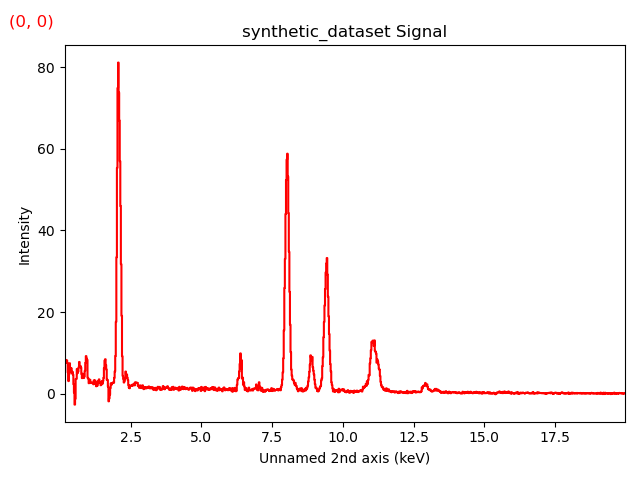

In [9]:
# Plot `s`
s.plot()

The first time, `plot` is called, the navigator is computed and saved in the `navigator` attribute. In this case, this was quite fast, because this signal has 5 chunks in the signal dimension and we used only a small portion of the whole dataset to compute the navigator.

Let's have a look at the data chunks:

In [10]:
s.data

dask.array<array, shape=(512, 512, 992), dtype=float64, chunksize=(64, 512, 248), chunktype=numpy.ndarray>

You can compute the navigator yourself and saved it to the `navigator` attribute or use the convenience method compute_navigator `compute_navigator`, for example by looking at specimen energy position:

In [11]:
s.compute_navigator(index=6.3)

INFO:hyperspy._signals.lazy:Using index: [307]
INFO:hyperspy._signals.lazy:Signal chunks: ((248, 248, 248, 248),)
INFO:hyperspy._signals.lazy:Computing sum over signal dimension: [slice(248, 496, None)]
INFO:hyperspy._signals.lazy:Rechunking.
Original chunks: ((64, 64, 64, 64, 64, 64, 64, 64), (512,), (248,))
INFO:hyperspy._signals.lazy:Final chunks: ((128, 128, 128, 128), (512,), (248,)) 
INFO:hyperspy._signals.eds:Live_time could not be found in the metadata and has not been updated.


[########################################] | 100% Completed |  2.3s


`compute_navigator` takes the sum over whole chunks to increase signal-to-noise ratio.

<IPython.core.display.Javascript object>


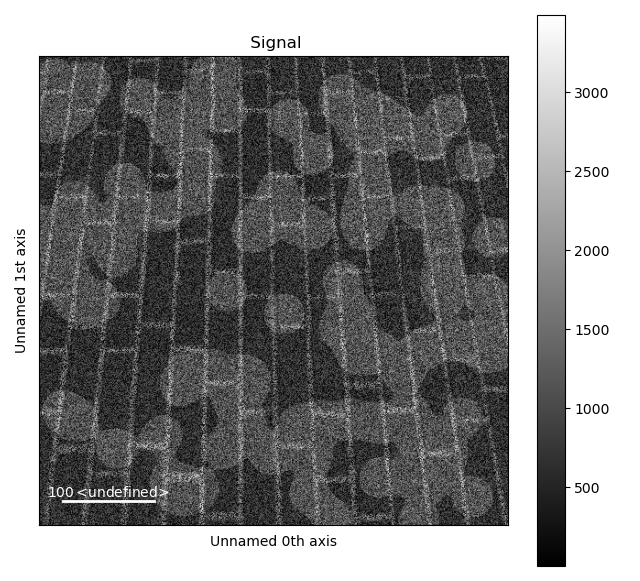

In [13]:
s.navigator.plot()

In [14]:
s2 = hs.load('synthetic_dataset_chunking.hspy', lazy=True)

In [15]:
s2.data

dask.array<array, shape=(512, 512, 992), dtype=float64, chunksize=(16, 512, 992), chunktype=numpy.ndarray>

As we can see, the signal dimension contains a single chunk. This makes plotting faster, because it avoids retrieve several chunks for the selected navigation position.

INFO:hyperspy._signals.lazy:Using index: [496]
INFO:hyperspy._signals.lazy:Signal chunks: ((992,),)
INFO:hyperspy._signals.lazy:Computing sum over signal dimension: [slice(0, 992, None)]
INFO:hyperspy._signals.lazy:Rechunking.
Original chunks: ((16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16), (512,), (992,))
INFO:hyperspy._signals.lazy:Final chunks: ((32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32), (512,), (992,)) 
INFO:hyperspy._signals.eds:Live_time could not be found in the metadata and has not been updated.


[########################################] | 100% Completed |  9.2s


<IPython.core.display.Javascript object>


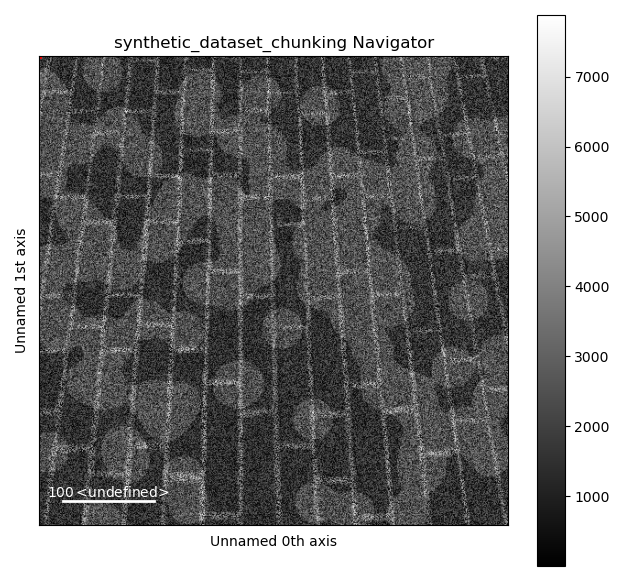

<IPython.core.display.Javascript object>


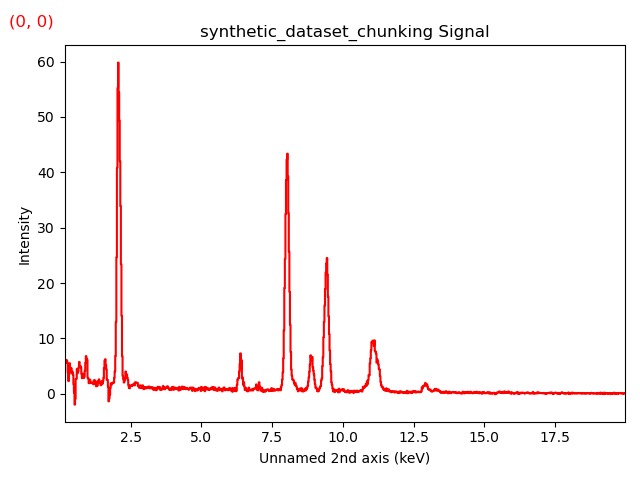

In [16]:
s2.plot()

## 4. EDS mapping
Lazy processing will follow the same syntax as for the non-lazy signal, expect that the `compute` will need to called.

Check the metadata to know if some element are already defined:

In [17]:
s.metadata

├── Acquisition_instrument
│   └── TEM
│       ├── Detector
│       │   └── EDS
│       │       ├── azimuth_angle = 0.0
│       │       ├── elevation_angle = 35.0
│       │       └── energy_resolution_MnKa = 130.0
│       └── Stage
│           └── tilt_alpha = 0.0
├── General
│   ├── FileIO
│   │   ├── 0
│   │   │   ├── hyperspy_version = 1.7.1
│   │   │   ├── io_plugin = hyperspy.io_plugins.hspy
│   │   │   ├── operation = save
│   │   │   └── timestamp = 2022-07-23T02:16:59.678905-06:00
│   │   └── 1
│   │       ├── hyperspy_version = 1.7.1
│   │       ├── io_plugin = hyperspy.io_plugins.hspy
│   │       ├── operation = load
│   │       └── timestamp = 2022-07-23T02:28:55.011807-06:00
│   └── title = 
├── Sample
│   └── elements = ['Fe', 'Pt']
└── Signal
    └── signal_type = EDS_TEM

We can extract X-ray line intensities as we would with non-lazy signal:

In [18]:
# Use the `get_lines_intensity` method to get the intensities of `Fe_Ka` and `Pt_La`
intensities = s.get_lines_intensity(['Fe_Ka', 'Pt_La'])

INFO:hyperspy._signals.lazy:Rechunking.
Original chunks: ((64, 64, 64, 64, 64, 64, 64, 64), (512,), (14,))
INFO:hyperspy._signals.lazy:Final chunks: ((512,), (512,), (14,)) 
INFO:hyperspy._signals.eds:Live_time could not be found in the metadata and has not been updated.
INFO:hyperspy._signals.lazy:Rechunking.
Original chunks: ((64, 64, 64, 64, 64, 64, 64, 64), (512,), (16,))
INFO:hyperspy._signals.lazy:Final chunks: ((512,), (512,), (16,)) 
INFO:hyperspy._signals.eds:Live_time could not be found in the metadata and has not been updated.


In [19]:
for intensity in intensities:
    intensity.compute()

[########################################] | 100% Completed |  1.9s
[########################################] | 100% Completed |  1.8s


<IPython.core.display.Javascript object>


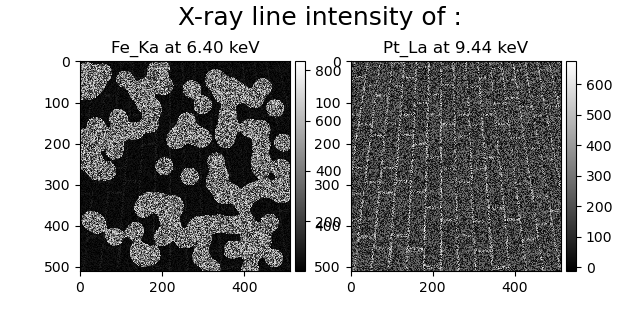

[<AxesSubplot:title={'center':'Fe_Ka at 6.40 keV'}>,
 <AxesSubplot:title={'center':'Pt_La at 9.44 keV'}>]

In [20]:
# Plot the intensity map using `hs.plot.plot_images`
hs.plot.plot_images(intensities)

## 5. Rebinning

In [21]:
s2 = hs.load('synthetic_dataset_chunking.hspy', lazy=True)

Now, we have significantly less chunks: 64 (4096/64) chunks instead of 4096 and there are all of egal size (64, 512, 512)

In [22]:
# use isig syntax to slice take the signal up to 15 eV and
# rebin the navigation dimention by a factor of 4 using the `rebin` method
s_rebin = s2.isig[:15.0].rebin(scale=(4, 4, 1))

INFO:hyperspy._signals.lazy:Rechunking.
Original chunks: ((16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16), (512,), (742,))
INFO:hyperspy._signals.lazy:Final chunks: ((512,), (128, 128, 128, 128), (149, 149, 148, 148, 148)) 
INFO:hyperspy._signals.eds:real_time could not be found in the metadata and has not been updated.
INFO:hyperspy._signals.eds:Live_time could not be found in the metadata and has not been updated.


In [23]:
# Call `compute` to perform the computation
s_rebin.compute()

[########################################] | 100% Completed | 10.6s


In [24]:
s_rebin

<EDSTEMSpectrum, title: , dimensions: (128, 128|742)>

`s_rebin` is not a lazy signal anymore.

INFO:hyperspy._signals.eds:Live_time could not be found in the metadata and has not been updated.


<IPython.core.display.Javascript object>


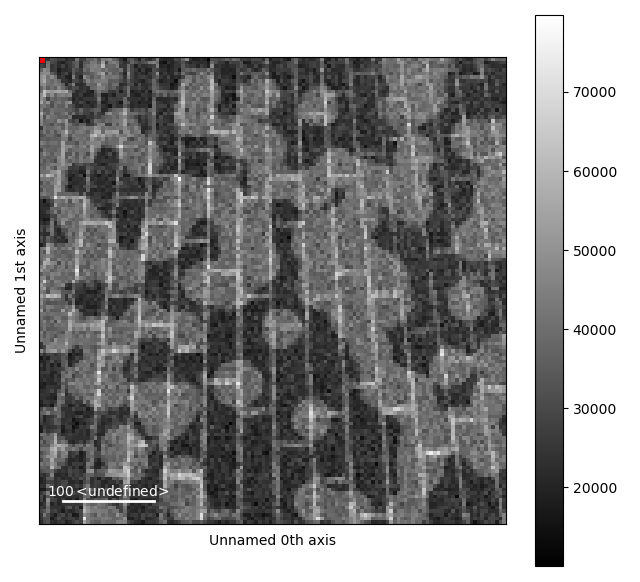

<IPython.core.display.Javascript object>


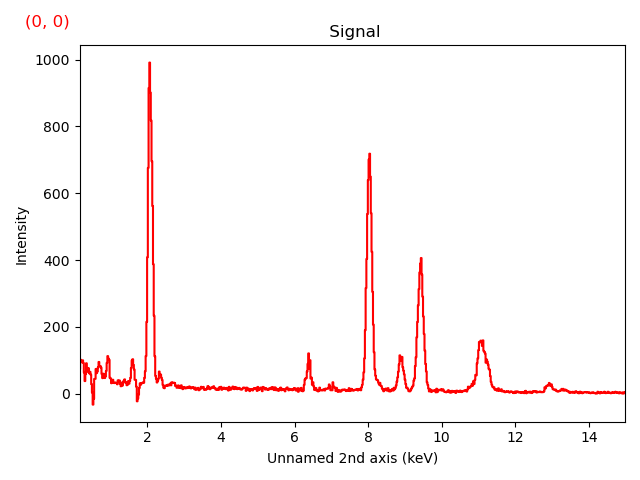

In [25]:
# Plot the result, which have been computed and is now in memory
s_rebin.plot()

## 6. ROI in navigation dimension

<IPython.core.display.Javascript object>


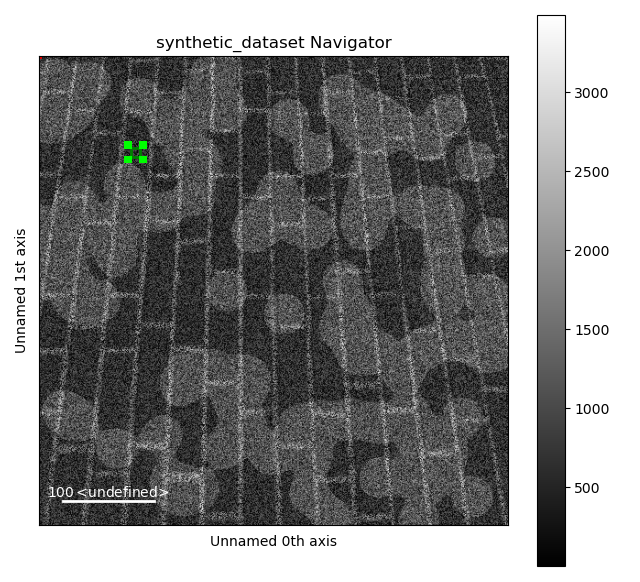

<IPython.core.display.Javascript object>


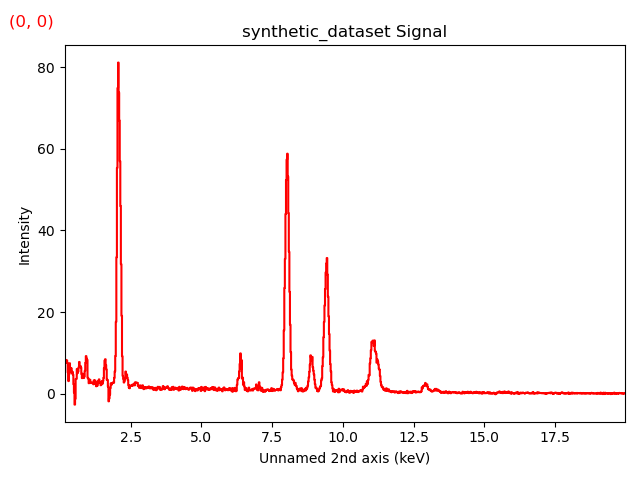

In [26]:
# Plot `s`
s.plot()

Let's create a rectagular ROI

In [27]:
# Create a RectangularROI defined by the position (left=100, top=100, right=110, bottom=110)
s_roi = hs.roi.RectangularROI(left=100, top=100, right=110, bottom=110)

In [28]:
# Check the ROI
print(s_roi)

RectangularROI(left=100, top=100, right=110, bottom=110)


Calling this object extracts a rectangular roi from a HyperSpy signal. For example:

In [29]:
# Call the ROI from a signal:
print(s_roi(s))

<LazyEDSTEMSpectrum, title: , dimensions: (10, 10|992)>


We can change its parameters interactively displaying the associated widget as follows:

In [30]:
# Call the `gui` method of the ROI to display the widget:
s_roi.gui()

In [31]:
# Check the changes in the roi:
print(s_roi(s))

<LazyEDSTEMSpectrum, title: , dimensions: (10, 10|992)>


And also by adding a widget to the navigator plot

In [32]:
# Add the ROI to the signal using the `add_widget` method of the roi:
w = s_roi.add_widget(s)

So far, we have to execute manually the ROI on the spectrum image every time that we change its parameters. We can perform this operation automatically instead:

In [33]:
# Use the `hs.interactive` function to automatically calculate a new signal from `s` and defined by the ROI:
s2 = hs.interactive(s_roi, signal=s,
                    event=s_roi.events.changed,
                    recompute_out_event=None)

In [34]:
# Get the information about `s2`:
print(s2)

<LazyEDSTEMSpectrum, title: , dimensions: (10, 10|992)>


We can use the ``interactive`` function to compute the sum of the extracted spectrum image interactively as follows:

In [35]:
# Use the `hs.interactive` function to automatically calculate the sum of `s2`:
s2_sum = hs.interactive(s2.sum,
                        event=s2.events.data_changed,
                        recompute_out_event=None)

INFO:hyperspy._signals.lazy:Rechunking.
Original chunks: ((10,), (10,), (248, 248, 248, 248))
INFO:hyperspy._signals.lazy:Final chunks: ((10,), (10,), (992,)) 
INFO:hyperspy._signals.eds:Live_time could not be found in the metadata and has not been updated.


In [36]:
# Check the information of `s2_sum`:
s2_sum

<LazyEDSTEMSpectrum, title: , dimensions: (|992)>

And plot it. Notice that the spectrum should update when we change the ROI parameters

<IPython.core.display.Javascript object>


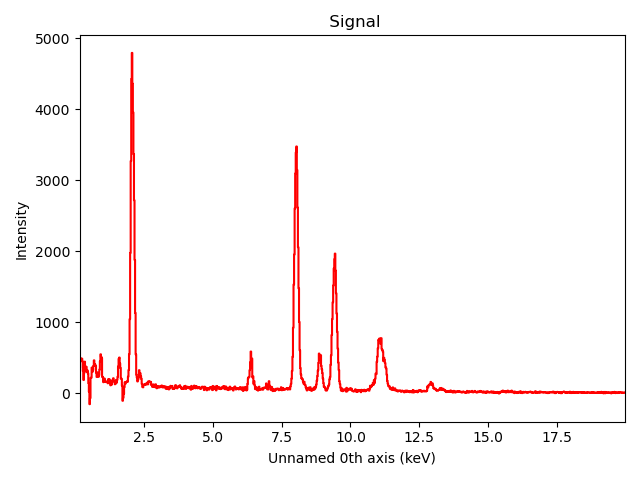

In [37]:
s2_sum.plot()

## 7. Summary

Most operations can be performed *lazily* in HyperSpy:
1. Visualisation
2. Slicing and indexing
3. Generic mathematical operations
4. Machine learning
5. Curve fitting

See [the big data section](https://hyperspy.readthedocs.io/en/stable/user_guide/big_data.html#limitations) of the HyperSpy documentation for more information and to learn about the main difference between lazy and non-lazy signal.